In [1]:
from ww.defs import Case, Interface2D
import numpy as np
from ww.prepare import read_p, read_fields
from ww.phase import extract_phase
import os
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
from ww.prepare import load_object
from tqdm import tqdm

%load_ext autoreload
%autoreload 3

### Define converting functions
Read in data from pickle, assemble xarray, and convert to netcdf.

In [9]:
from scipy.interpolate import griddata
import pandas as pd
from ww.prepare import load_object
from scipy.signal import hilbert

########## Interpolate eta onto dataset coordinate and store as new variable ############
def read_eta (time, casepath):
    
    filename = casepath + 'eta/eta_loc_t%g' %time
    pruningz = 1+0.4/4.
    snapshot = pd.read_table(filename, delimiter = ',')
    
    # Some cleaning
    snapshot = snapshot[snapshot.x != 'x']
    snapshot = snapshot.astype('float')
    snapshot = snapshot[snapshot.pos < pruningz] # Exclude data over slope 0.4
    snapshot = snapshot[abs(snapshot.p-snapshot.p.mean()) < 10**(-1)] # Extra pruning for wild p
    snapshot = snapshot[np.isinf(snapshot.epsilon) == 0] # Gradient showing inf
    snapshot = snapshot.sort_values(by=['x','z'])  
    
    return snapshot
    
########## Read 3D fields from slices and read eta from x-y-variable formatted file #######
def read_field (time, casepath):
    
    ux_3D = {'name':'ux', 'value':[]}
    uy_3D = {'name':'uy', 'value':[]}
    # uz_3D = {'name':'uz', 'value':[]} # Alas we didn't save uz_3D 
    f_3D = {'name':'f', 'value':[]} # We choose to not save f_3D
    pair_3D = {'name':'pair', 'value':[]}

    for field in (ux_3D, uy_3D, f_3D, pair_3D):
        
        picklename = casepath + 'field/' + 'pickle_tiger/' + field['name'] +'_t%g' % time +'.pkl'
        exists = os.path.exists(picklename)

        # If the pickle is there read in the pickles
        if exists:
            field['value'] = load_object(picklename)
            print('pickle restored!')

        x = np.linspace(-np.pi, np.pi, 512, endpoint=False) + 2*np.pi/512/2
        y = np.linspace(0, 2*np.pi, 512, endpoint=False) + 2*np.pi/512/2
        z = np.linspace(-np.pi, np.pi, 256, endpoint=False) + 2*np.pi/256/2

        data = np.full((256, 512, 512), np.nan)   
        data[1:] = field['value'][:, :, :] # We only saved 255 slices

        da = xr.DataArray(data, dims=['z', 'x', 'y'], coords={'x': x, 'y': y, 'z': z})
        da.name = field['name']
        field['da'] = da

    ds = xr.merge([ux_3D['da'], uy_3D['da'], f_3D['da'], pair_3D['da']])
    return ds

############ Compute phase using Hilbert Transform ##############
def compute_phase(eta_1D): 
    
    analytic_signal = hilbert(eta_1D)
    phase = np.angle(analytic_signal)
    return phase

In [10]:
########### Put together read and save ################
def read_and_save (case, tsimu):

    # Read 3D fields from slices and read eta from x-y-variable formatted file (2D)
    ds = read_field(tsimu, case.path)
    snapshot = read_eta(tsimu, case.path) 

    # Interpolate eta onto dataset coordinate and store as new variable
    xtile, ztile = np.meshgrid(ds.x.values, ds.z.values)
    eta = griddata((snapshot.x, snapshot.z), snapshot.pos, (xtile, ztile), method='linear')
    ds['eta'] = (('z','x'), eta)

    # Compute phase and store as new variable (1D)
    eta_1D = ds['eta'].mean(dim='z') - ds['eta'].mean(dim=['z','x'])
    ds['phase'] = (('x'), compute_phase(eta_1D))

    # Add a time dimension and metadata and save to netcdf
    ds = ds.expand_dims({'t': np.float64([tsimu-case.tstart])})
    ds = ds.assign_attrs(
        ustar=case.ustar, Retau=case.Retau, Bo=case.Bo, g=case.g, 
        ak=case.ak, LEVEL=case.LEVEL, emax=case.emax, alterMU=case.alterMU, 
        folder=case.path, tstart=case.tstart
    )
    return ds 

### Manually convert cases of interests
Change: case, folder_path, and interested time steps. This might take about a minute per time step.

In [37]:
# Define uniform compression settings
compression_settings = {
    'zlib': True,          # Enable zlib compression
    'complevel': 8,        # Set the compression level (1-9)
    'shuffle': True        # Enable the shuffle filter
}

# Case
# case = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.15, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
#              PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/rerun/', prefix='curved_fixREtau_boundary_')
# case.tstart = 44
# tseries = np.arange(45,60,1)

# case = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.2, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
#              PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
# case.tstart = 57
# tseries = np.arange(58,113,1)

# case = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.2, LEVEL=10, emax=0.3, alterMU=8, NOMATCH=True, 
#              PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
# case.tstart = 57
# tseries = np.arange(58,101,1)

case = Case(ustar=0.25, Retau=720, Bo=200, g=16, ak=0.2, LEVEL=10, emax=0.3, alterMU=4, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case.tstart = 57
tseries = np.arange(58,73,1)

# Specify the path of the new folder
folder_path = '/projects/DEIKE/jiarongw/ctr/data/case3/'
os.makedirs(folder_path, exist_ok=True)

for t in tseries: 
    ds = read_and_save (case, t)
    print('loaded t = %g, saving... ' %t)
    encoding = {var: compression_settings for var in ds.data_vars}
    ds.to_netcdf(folder_path + 'field%g.nc' %(t-case.tstart), 
                 encoding=encoding, engine='netcdf4', mode='w') 
    print('saved!')

/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_boundary_REtau720_BO200_g16_ak0.2_MU4_LEVEL10_emax0.3/
mu1 = 3.06825e-05, rho1 = 1, mu2 = 2.24719e-06, rho2 = 0.001225, sigma = 0.005
Given k = 4 (1/m), calculated omega = 8.01998 (1/s), period = 0.783442 (s), phase speed c = 2.00499 (m/s), wavelength = 1.5708 (m), Bo = 200
g = 16, c = 2.00499, Ustar = 0.25, MURATIO = 0.01831, mu_w = 3.06825e-05, rho_w = 1, mu_a = 2.24719e-06, rho_a = 0.001225, sigma = 0.005, Bo = 200, RE = 102646, Re_tau = 720
RELEASETIME = 57, uemax = 0.075 
srun: Job step aborted: Waiting up to 47 seconds for job step to finish.
slurmstepd: error: *** STEP 7313935.0 ON tiger-h19c1n14 CANCELLED AT 2021-09-30T13:42:50 DUE TO TIME LIMIT ***

pickle restored!
pickle restored!
pickle restored!
pickle restored!
loaded t = 58, saving... 
saved!
pickle restored!
pickle restored!
pickle restored!
pickle restored!
loaded t = 59, saving... 
saved!
pickle restored!
pickle restored!
pickle restored!
pickle restored!
loaded t = 

### Test multiple file read-in 
Concatenate along the time axis.

In [22]:
######## Additional option 1 ###########
# from functools import partial
# def _preprocess(x, lon_bnds, lat_bnds):
#     return x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds))
# lon_bnds, lat_bnds = (-110, -105), (40, 45)
# partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
# ds = xr.open_mfdataset(
#     "file_*.nc", concat_dim="time", preprocess=partial_func
# )  

######## Additional option 2 ###########
# ds = xr.open_mfdataset(
#     "file.nc", drop_variables=["varname_1", "varname_2"]  # any list of vars
# )  

ds = xr.open_mfdataset(
    '/projects/DEIKE/jiarongw/ctr/data/case1/field*.nc', 
    concat_dim='t', combine='nested', chunks={'z':-1, 'x':-1, 'y':-1})  

In [15]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (t: 2, z: 256, x: 512, y: 512)
Coordinates:
  * t        (t) float64 16B 1.0 2.0
  * x        (x) float64 4kB -3.135 -3.123 -3.111 -3.099 ... 3.111 3.123 3.135
  * y        (y) float64 4kB 0.006136 0.01841 0.03068 ... 6.253 6.265 6.277
  * z        (z) float64 2kB -3.129 -3.105 -3.08 -3.056 ... 3.08 3.105 3.129
Data variables:
    ux       (t, z, x, y) float64 1GB dask.array<chunksize=(1, 4, 512, 512), meta=np.ndarray>
    uy       (t, z, x, y) float64 1GB dask.array<chunksize=(1, 4, 512, 512), meta=np.ndarray>
    f        (t, z, x, y) float64 1GB dask.array<chunksize=(1, 4, 512, 512), meta=np.ndarray>
    pair     (t, z, x, y) float64 1GB dask.array<chunksize=(1, 4, 512, 512), meta=np.ndarray>
    eta      (t, z, x) float64 2MB dask.array<chunksize=(1, 4, 512), meta=np.ndarray>
    phase    (t, x) float64 8kB dask.array<chunksize=(1, 512), meta=np.ndarray>
Attributes:
    ustar:    0.25
    Retau:    720
    Bo:       200
    g:        1
    ak:       0.2
    LEVEL:    10
    emax:     0.3
    alterMU:  16
    folder:   /projects/DEIKE/jiarongw/turbulence/curved_fixREtau_boundary_RE...
    tstart:   57

In [28]:
mean = ds.pair.isel(t=0,y=slice(200,500)).mean(dim=['z','x','y'])

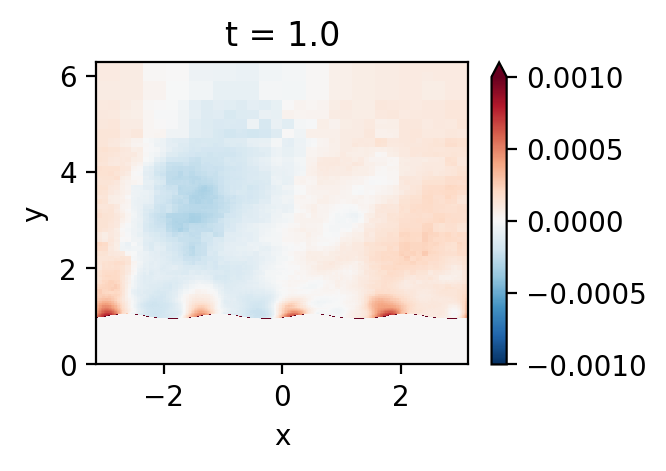

In [34]:
fig = plt.figure(figsize=[3,2],dpi=200)
pair_mod = (ds.pair.isel(t=0).mean(dim=['z']) - mean)*(1-ds.f.isel(t=0)).mean(dim=['z'])
pair_mod.plot(x='x', vmin=-0.001, vmax=0.001, cmap='RdBu_r')

In [ ]:
# Adding attributes to specific variables
# ds['temperature'].attrs['units'] = 'Celsius'

### A list of old runs

In [92]:
######### ak = 0.2 ##########
case_pre = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.2, LEVEL=10, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
                 working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_precursor_')
print(case_pre.path)
case_pre.tstart = 53
tseries = np.arange(53, 64, 1)
# todo: write some other eta function

######### ak = 0.1 ##########
case_pre = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.1, LEVEL=10, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
                 working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_precursor_')
case_pre.tstart = 55
print(case_pre.path)
tseries = np.arange(56, 65, 1)

# case_pre = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.1, LEVEL=10, emax=0.1, OUTLEVEL=9, PRECURSOR=True,
#                  working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_precursor_')
# case_pre.tstart = 55

######### ak = 0.15 ##########

case_pre = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.15, LEVEL=10, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
                 working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_precursor_')
case_pre.tstart = 20


case_pre = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.15, LEVEL=10, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
                 working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_precursor_', postfix='_new/')
case_pre.tstart = 40

# case_pre = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.15, LEVEL=10, emax=0.1, OUTLEVEL=9, PRECURSOR=True,
#                  working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_precursor_')
# case_pre.tstart = 23


########## ak = 0.3 #########
case_pre = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.3, LEVEL=10, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
                 working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_precursor_')
case_pre.tstart = 33 



/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_precursor_REtau720_ak0.2_LEVEL10_emax0.3/
/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_precursor_REtau720_ak0.1_LEVEL10_emax0.3/


In [ ]:
####### TODO: find the precursor #########




####### ak = 0.1 ###########

case = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.1, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/rerun/', prefix='curved_fixREtau_boundary_')
case.tstart = 66
tseries = np.arange(67,90,1) 

case = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.1, LEVEL=10, emax=0.3, alterMU=8, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/rerun/', prefix='curved_fixREtau_boundary_')
case.tstart = 66
tseries = np.arange(67,86,1)

case = Case(ustar=0.25, Retau=720, Bo=200, g=16, ak=0.1, LEVEL=10, emax=0.3, alterMU=4, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/rerun/', prefix='curved_fixREtau_boundary_')
case.tstart = 66
tseries = np.arange(67,83,1) 

####### ak = 0.15 ##########

case = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.15, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/rerun/', prefix='curved_fixREtau_boundary_')
case.tstart = 44
tseries = np.arange(45,60,1)

case = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.15, LEVEL=10, emax=0.3, alterMU=8, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/rerun/', prefix='curved_fixREtau_boundary_')
case.tstart = 44
tseries = np.arange(45,63,1)

case = Case(ustar=0.25, Retau=720, Bo=200, g=16, ak=0.15, LEVEL=10, emax=0.3, alterMU=4, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/rerun/', prefix='curved_fixREtau_boundary_')
case.tstart = 44
tseries = np.arange(45,59,1) 

####### ak = 0.2 ###########

case = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.2, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case.tstart = 57
tseries = np.arange(58,113,1)

case = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.2, LEVEL=10, emax=0.3, alterMU=8, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case.tstart = 57
tseries = np.arange(58,101,1)

case = Case(ustar=0.25, Retau=720, Bo=200, g=16, ak=0.2, LEVEL=10, emax=0.3, alterMU=4, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case.tstart = 57
tseries = np.arange(58,73,1)

case_pre = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.2, LEVEL=10, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
                 working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_precursor_')
case_pre.tstart = 53


####### ak = 0.3 ###########
        
# case = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.3, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
#              PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/rerun/', prefix='curved_fixREtau_boundary_')
# case.tstart = 40.5
# tseries = np.arange(41,78,1)

# case = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.3, LEVEL=10, emax=0.3, alterMU=8, NOMATCH=True, 
#              PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/rerun/', prefix='curved_fixREtau_boundary_')
# case.tstart = 40.5
# tseries = np.arange(41,57,1)

# case = Case(ustar=0.25, Retau=720, Bo=200, g=16, ak=0.3, LEVEL=10, emax=0.3, alterMU=4, NOMATCH=True, 
#              PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/rerun/', prefix='curved_fixREtau_boundary_')
# case.tstart = 40.5
# tseries = np.arange(41,54,1)

In [ ]:
case_swell = Case(ustar=0.25, Retau=720, Bo=200, g=128, ak=0.15, LEVEL=10, emax=0.3, alterMU=1, NOMATCH=True, 
                  PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case_swell.tstart = 43

In [ ]:
########### Why did I rerun 0.1 on top of these? #############
case4 = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.1, LEVEL=10, emax=0.1, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case4.tstart = 307
case5 = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.1, LEVEL=10, emax=0.1, alterMU=8, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case5.tstart = 301.5
case6 = Case(ustar=0.25, Retau=720, Bo=200, g=16, ak=0.1, LEVEL=10, emax=0.1, alterMU=4, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case6.tstart = 307

########### Why did I rerun 0.15 on top of these? #############
case7 = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.15, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case7.tstart = 43
case8 = Case(ustar=0.25, Retau=720, Bo=200, g=2.25, ak=0.15, LEVEL=10, emax=0.3, alterMU=10.666, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case8.tstart = 43
case9 = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.15, LEVEL=10, emax=0.3, alterMU=8, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case9.tstart = 43
case10 = Case(ustar=0.25, Retau=720, Bo=200, g=9, ak=0.15, LEVEL=10, emax=0.3, alterMU=5.333, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case10.tstart = 43
case11 = Case(ustar=0.25, Retau=720, Bo=200, g=16, ak=0.15, LEVEL=10, emax=0.3, alterMU=4, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case11.tstart = 43
case12 = Case(ustar=0.25, Retau=720, Bo=200, g=36, ak=0.15, LEVEL=10, emax=0.3, alterMU=2.666, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case12.tstart = 43
case13 = Case(ustar=0.25, Retau=720, Bo=200, g=64, ak=0.15, LEVEL=10, emax=0.3, alterMU=2, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, working_dir='/projects/DEIKE/jiarongw/turbulence/', prefix='curved_fixREtau_boundary_')
case13.tstart = 43
